In [11]:
"""
Hierarchical Risk Parity (HRP) Implementation
Uses machine learning clustering to build diversified portfolios
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Plotting setup
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Project setup
project_root = Path.cwd().parent
(project_root / 'results/figures/hrp').mkdir(parents=True, exist_ok=True)
(project_root / 'results/metrics').mkdir(parents=True, exist_ok=True)
(project_root / 'models').mkdir(parents=True, exist_ok=True)

print("="*70)
print("HIERARCHICAL RISK PARITY (HRP) PORTFOLIO OPTIMIZATION")
print("="*70)
print("Loading data...")

# Load clean data
prices = pd.read_csv(project_root / 'data/processed/prices_clean.csv', 
                     index_col=0, parse_dates=True)
returns = pd.read_csv(project_root / 'data/processed/returns_clean.csv', 
                      index_col=0, parse_dates=True)

print(f"✅ Prices: {prices.shape}")
print(f"✅ Returns: {returns.shape}")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")


HIERARCHICAL RISK PARITY (HRP) PORTFOLIO OPTIMIZATION
Loading data...
✅ Prices: (1182, 55)
✅ Returns: (1182, 55)
Date range: 2021-03-12 to 2025-11-21


In [12]:
"""
Core HRP Algorithm Implementation
"""

def calculate_correlation_matrix(returns):
    """Calculate correlation matrix from returns"""
    return returns.corr()

def correlation_to_distance(corr_matrix):
    """
    Convert correlation matrix to distance matrix
    Distance = sqrt(0.5 * (1 - correlation))
    """
    distance = np.sqrt(0.5 * (1 - corr_matrix))
    return distance

def get_quasi_diag(link):
    """
    Reorder the correlation matrix to quasi-diagonal form
    by sorting based on hierarchical clustering
    """
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]
    
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j, 0]
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df0])
        sort_ix = sort_ix.sort_index()
        sort_ix.index = range(sort_ix.shape[0])
    
    return sort_ix.tolist()

def get_cluster_var(cov, c_items):
    """Calculate cluster variance"""
    cov_slice = cov.loc[c_items, c_items]
    w_ = 1.0 / np.diag(cov_slice)
    w_ /= w_.sum()
    cluster_var = np.dot(np.dot(w_, cov_slice), w_)
    return cluster_var

def get_rec_bipart(cov, sort_ix):
    """
    Recursive bisection to calculate HRP weights
    """
    w = pd.Series(1.0, index=sort_ix)
    c_items = [sort_ix]
    
    while len(c_items) > 0:
        c_items = [i[j:k] for i in c_items 
                   for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) 
                   if len(i) > 1]
        
        for i in range(0, len(c_items), 2):
            c_items0 = c_items[i]
            c_items1 = c_items[i + 1]
            
            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)
            
            alpha = 1 - c_var0 / (c_var0 + c_var1)
            
            w[c_items0] *= alpha
            w[c_items1] *= 1 - alpha
    
    return w

def calculate_hrp_weights(returns):
    """
    Main HRP algorithm
    Returns: weights, correlation matrix, distance matrix, linkage
    """
    # Step 1: Calculate correlation matrix
    corr = calculate_correlation_matrix(returns)
    
    # Step 2: Convert to distance matrix
    dist = correlation_to_distance(corr)
    
    # Step 3: Hierarchical clustering
    dist_condensed = squareform(dist, checks=False)
    link = linkage(dist_condensed, method='single')
    
    # Step 4: Get quasi-diagonal ordering
    sort_ix = get_quasi_diag(link)
    sort_ix = corr.index[sort_ix].tolist()
    
    # Step 5: Calculate covariance matrix
    cov = returns.cov()
    
    # Step 6: Recursive bisection for weights
    weights = get_rec_bipart(cov, sort_ix)
    
    return weights, corr, dist, link, sort_ix

print("✅ HRP helper functions defined")


✅ HRP helper functions defined


In [13]:
"""
Calculate HRP weights for the entire universe
"""

print("\n" + "="*70)
print("CALCULATING HRP WEIGHTS")
print("="*70)

# Use last 252 days (1 year) of data for initial calculation
lookback_period = 252
recent_returns = returns.iloc[-lookback_period:]

print(f"Using {lookback_period} days of returns data")
print(f"Date range: {recent_returns.index[0].date()} to {recent_returns.index[-1].date()}")

# Calculate HRP weights
hrp_weights, corr_matrix, dist_matrix, linkage_matrix, sorted_tickers = \
    calculate_hrp_weights(recent_returns)

print(f"\n✅ HRP weights calculated")
print(f"\nTop 10 Allocations:")
print(hrp_weights.sort_values(ascending=False).head(10))
print(f"\nBottom 10 Allocations:")
print(hrp_weights.sort_values(ascending=False).tail(10))

print(f"\nWeight Statistics:")
print(f"  Sum of weights: {hrp_weights.sum():.4f}")
print(f"  Mean weight: {hrp_weights.mean():.4f}")
print(f"  Median weight: {hrp_weights.median():.4f}")
print(f"  Max weight: {hrp_weights.max():.4f}")
print(f"  Min weight: {hrp_weights.min():.4f}")
print(f"  Std dev: {hrp_weights.std():.4f}")

# Calculate equal-weighted portfolio for comparison
equal_weights = pd.Series(1.0 / len(returns.columns), index=returns.columns)
print(f"\n📊 Equal-weighted allocation: {equal_weights.iloc[0]:.4f} per asset")



CALCULATING HRP WEIGHTS
Using 252 days of returns data
Date range: 2024-11-20 to 2025-11-21

✅ HRP weights calculated

Top 10 Allocations:
AGG    0.629496
MCD    0.043426
JNJ    0.027673
ABT    0.023601
TJX    0.017183
RTX    0.015582
WMT    0.014417
EFA    0.012984
UPS    0.008434
LLY    0.008047
dtype: float64

Bottom 10 Allocations:
META    0.002643
WFC     0.002531
AXP     0.002209
C       0.002172
MS      0.002078
GS      0.002055
ORCL    0.001996
NVDA    0.001444
AVGO    0.001301
TSLA    0.000899
dtype: float64

Weight Statistics:
  Sum of weights: 1.0000
  Mean weight: 0.0182
  Median weight: 0.0055
  Max weight: 0.6295
  Min weight: 0.0009
  Std dev: 0.0843

📊 Equal-weighted allocation: 0.0182 per asset



VISUALIZING HIERARCHICAL CLUSTERING


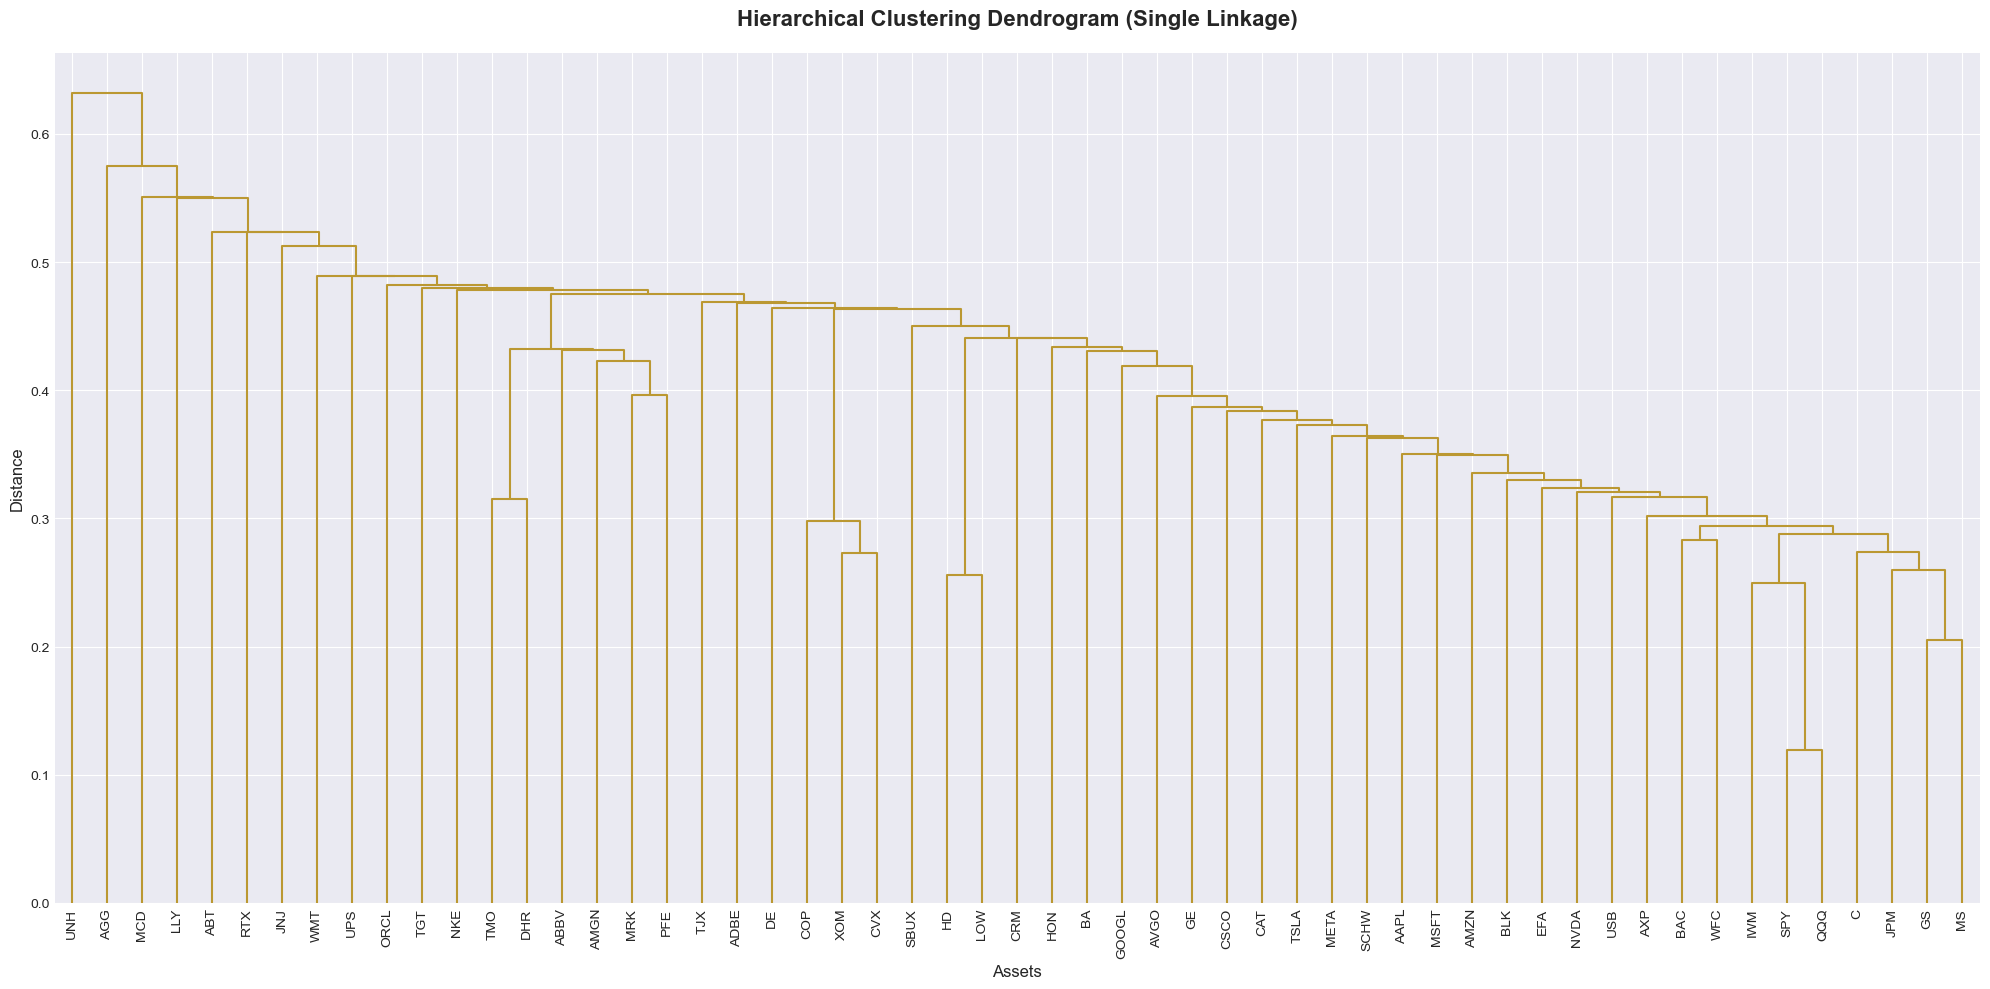

✅ Dendrogram saved to results/figures/hrp/01_clustering_dendrogram.png

Assets grouped into 8 clusters:

Cluster 1 (48 assets):
  AAPL, MSFT, GOOGL, NVDA, META, AVGO, ADBE, CRM, ORCL, CSCO, JPM, BAC, WFC, GS, MS, C, BLK, SCHW, AXP, USB, ABBV, MRK, PFE, TMO, DHR, AMGN, AMZN, TSLA, WMT, HD, NKE, SBUX, TGT, LOW, TJX, XOM, CVX, COP, BA, CAT, HON, UPS, GE, DE, SPY, QQQ, IWM, EFA

Cluster 2 (1 assets):
  JNJ

Cluster 3 (1 assets):
  RTX

Cluster 4 (1 assets):
  ABT

Cluster 5 (1 assets):
  LLY

Cluster 6 (1 assets):
  MCD

Cluster 7 (1 assets):
  AGG

Cluster 8 (1 assets):
  UNH


In [14]:
"""
Visualize the hierarchical clustering dendrogram
"""

print("\n" + "="*70)
print("VISUALIZING HIERARCHICAL CLUSTERING")
print("="*70)

fig, ax = plt.subplots(figsize=(20, 10))

# Create dendrogram
dendrogram(linkage_matrix, 
           labels=returns.columns,
           ax=ax,
           leaf_font_size=10,
           color_threshold=0.7)

ax.set_title('Hierarchical Clustering Dendrogram (Single Linkage)', 
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Assets', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(project_root / 'results/figures/hrp/01_clustering_dendrogram.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("✅ Dendrogram saved to results/figures/hrp/01_clustering_dendrogram.png")

# Identify clusters at a specific threshold
num_clusters = 8
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
cluster_assignments = pd.Series(clusters, index=returns.columns)

print(f"\nAssets grouped into {num_clusters} clusters:")
for i in range(1, num_clusters + 1):
    cluster_members = cluster_assignments[cluster_assignments == i].index.tolist()
    print(f"\nCluster {i} ({len(cluster_members)} assets):")
    print(f"  {', '.join(cluster_members)}")


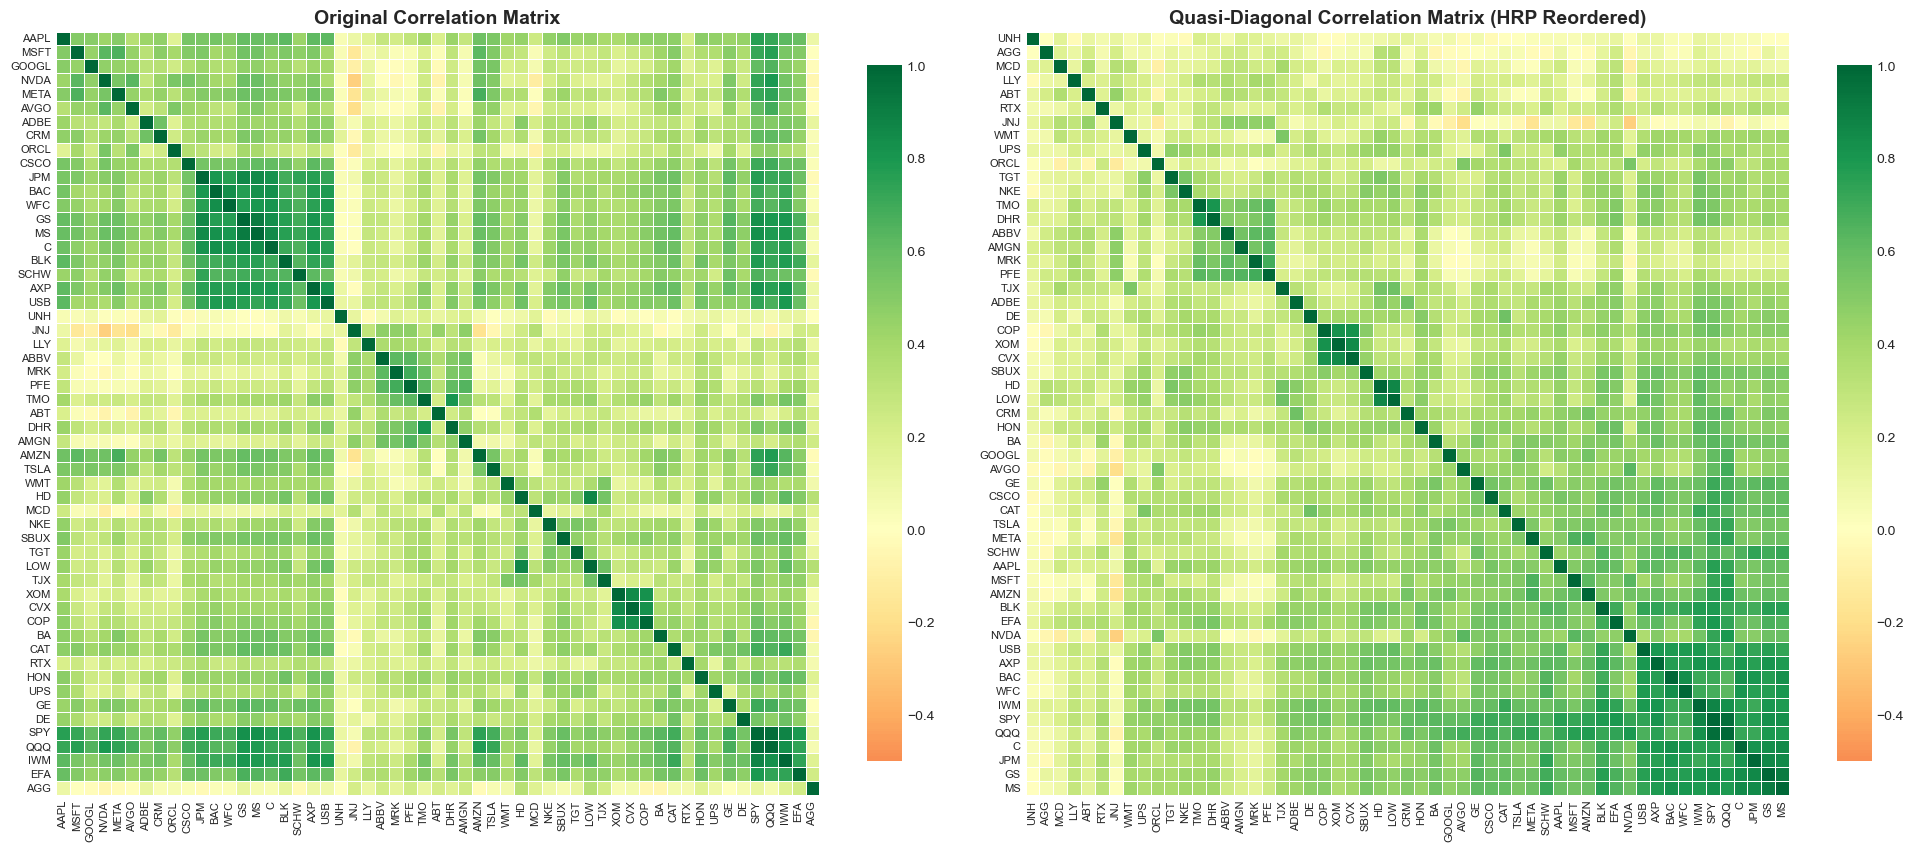

✅ Correlation matrices saved


In [15]:
"""
Visualize correlation matrix in original and quasi-diagonal order
"""

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Original correlation matrix
ax1 = axes[0]
sns.heatmap(corr_matrix, cmap='RdYlGn', center=0, vmin=-0.5, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=ax1, xticklabels=True, yticklabels=True)
ax1.set_title('Original Correlation Matrix', fontsize=14, fontweight='bold')
plt.setp(ax1.get_xticklabels(), rotation=90, fontsize=8)
plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=8)

# Quasi-diagonal correlation matrix (reordered)
corr_reordered = corr_matrix.loc[sorted_tickers, sorted_tickers]
ax2 = axes[1]
sns.heatmap(corr_reordered, cmap='RdYlGn', center=0, vmin=-0.5, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=ax2, xticklabels=True, yticklabels=True)
ax2.set_title('Quasi-Diagonal Correlation Matrix (HRP Reordered)', 
             fontsize=14, fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=90, fontsize=8)
plt.setp(ax2.get_yticklabels(), rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig(project_root / 'results/figures/hrp/02_correlation_matrices.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("✅ Correlation matrices saved")


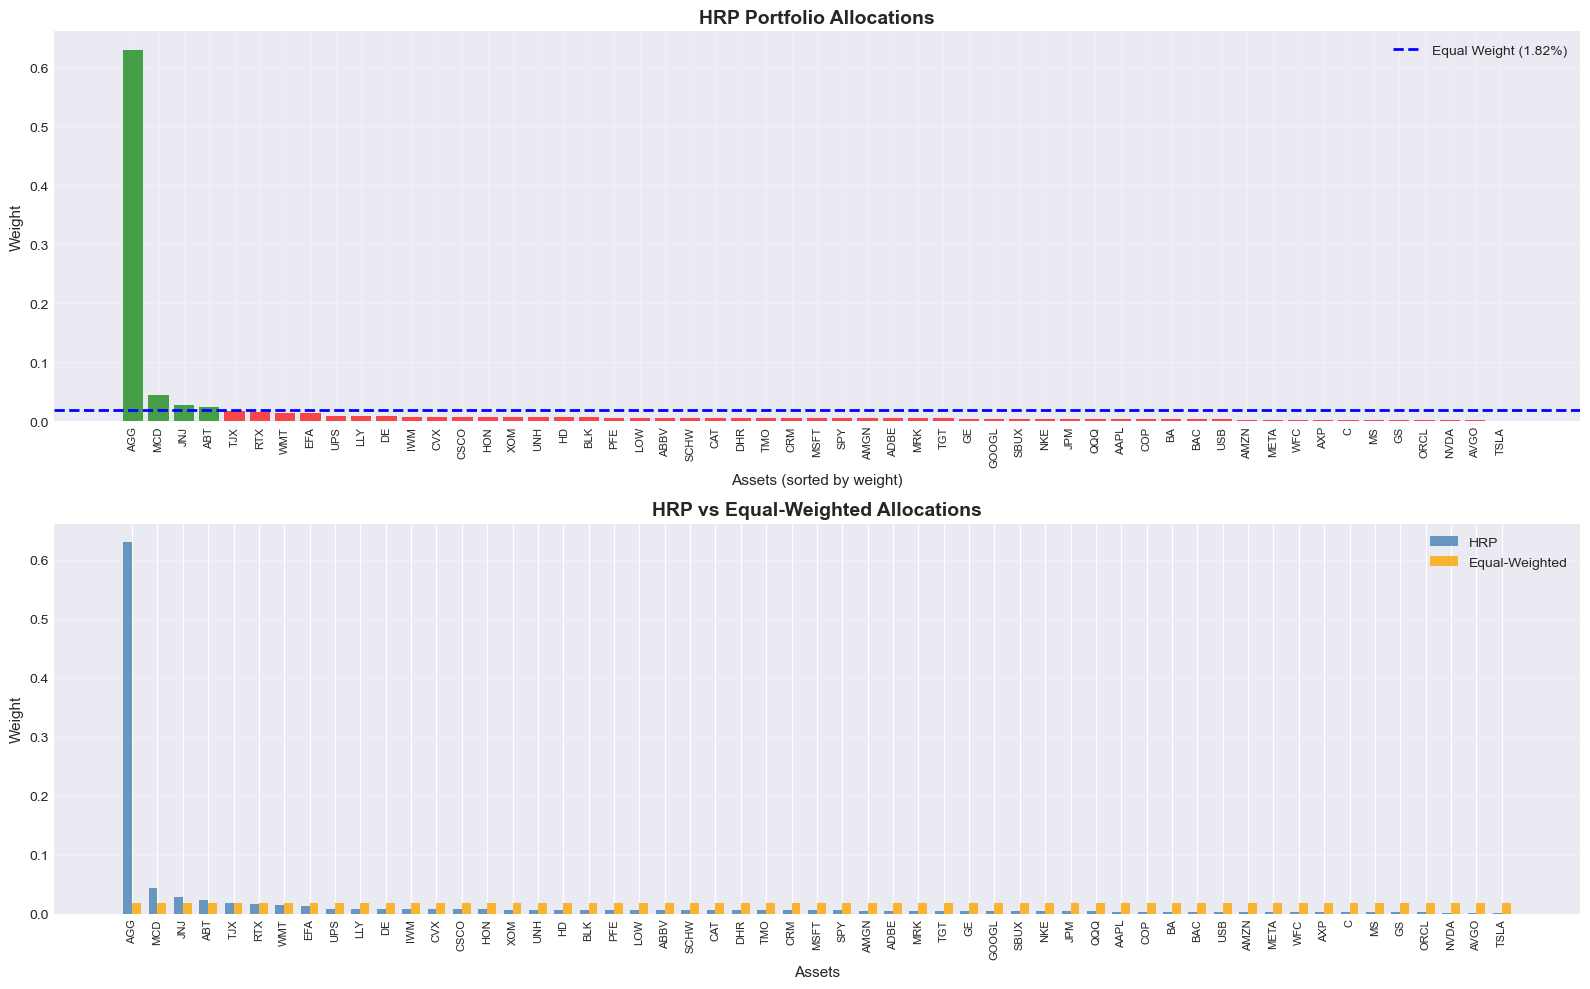

✅ Allocation charts saved


In [16]:
"""
Visualize HRP weights vs Equal-weighted
"""

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# HRP weights
ax1 = axes[0]
hrp_sorted = hrp_weights.sort_values(ascending=False)
colors = ['green' if w > equal_weights.iloc[0] else 'red' for w in hrp_sorted]
ax1.bar(range(len(hrp_sorted)), hrp_sorted.values, color=colors, alpha=0.7)
ax1.axhline(equal_weights.iloc[0], color='blue', linestyle='--', 
           linewidth=2, label=f'Equal Weight ({equal_weights.iloc[0]:.2%})')
ax1.set_title('HRP Portfolio Allocations', fontsize=14, fontweight='bold')
ax1.set_ylabel('Weight', fontsize=11)
ax1.set_xlabel('Assets (sorted by weight)', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(len(hrp_sorted)))
ax1.set_xticklabels(hrp_sorted.index, rotation=90, fontsize=8)

# Weight comparison
ax2 = axes[1]
comparison = pd.DataFrame({
    'HRP': hrp_weights,
    'Equal-Weighted': equal_weights
}).sort_values('HRP', ascending=False)

x = np.arange(len(comparison))
width = 0.35
ax2.bar(x - width/2, comparison['HRP'], width, label='HRP', alpha=0.8, color='steelblue')
ax2.bar(x + width/2, comparison['Equal-Weighted'], width, label='Equal-Weighted', 
       alpha=0.8, color='orange')
ax2.set_title('HRP vs Equal-Weighted Allocations', fontsize=14, fontweight='bold')
ax2.set_ylabel('Weight', fontsize=11)
ax2.set_xlabel('Assets', fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels(comparison.index, rotation=90, fontsize=8)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(project_root / 'results/figures/hrp/03_hrp_allocations.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("✅ Allocation charts saved")


In [17]:
"""
Backtest HRP with quarterly rebalancing (2019-2024)
"""

print("\n" + "="*70)
print("BACKTESTING HRP WITH QUARTERLY REBALANCING")
print("="*70)

def backtest_portfolio(returns, weights_dict, rebalance_freq='Q'):
    """
    Backtest portfolio with periodic rebalancing
    
    Parameters:
    - returns: DataFrame of returns
    - weights_dict: Dictionary of {date: weights_series}
    - rebalance_freq: 'Q' for quarterly, 'M' for monthly
    
    Returns: portfolio returns, weights over time
    """
    portfolio_returns = []
    portfolio_weights = []
    current_weights = None
    rebalance_dates = []
    
    for date in returns.index:
        # Check if we need to rebalance
        if date in weights_dict:
            current_weights = weights_dict[date]
            rebalance_dates.append(date)
        
        if current_weights is not None:
            # Calculate portfolio return for this day
            day_return = (returns.loc[date] * current_weights).sum()
            portfolio_returns.append(day_return)
            portfolio_weights.append(current_weights.copy())
        else:
            portfolio_returns.append(np.nan)
            portfolio_weights.append(None)
    
    portfolio_returns = pd.Series(portfolio_returns, index=returns.index)
    return portfolio_returns, portfolio_weights, rebalance_dates

# Define backtest period (2019-2024)
backtest_start = '2019-01-01'
backtest_end = returns.index[-1]
backtest_returns = returns.loc[backtest_start:backtest_end]

print(f"Backtest period: {backtest_returns.index[0].date()} to {backtest_returns.index[-1].date()}")
print(f"Total days: {len(backtest_returns)}")

# Generate quarterly rebalance dates
quarterly_dates = pd.date_range(start=backtest_start, 
                                end=backtest_end, 
                                freq='Q')

# Calculate HRP weights at each rebalance date
hrp_weights_over_time = {}
equal_weights_over_time = {}

print(f"\nCalculating HRP weights at {len(quarterly_dates)} rebalance dates...")

for i, rebal_date in enumerate(quarterly_dates):
    # Find closest available date in our data
    available_dates = backtest_returns.index[backtest_returns.index <= rebal_date]
    if len(available_dates) == 0:
        continue
    actual_date = available_dates[-1]
    
    # Use previous 252 days for weight calculation
    lookback_start = backtest_returns.index.get_loc(actual_date) - lookback_period
    if lookback_start < 0:
        lookback_start = 0
    
    hist_returns = backtest_returns.iloc[lookback_start:backtest_returns.index.get_loc(actual_date)]
    
    if len(hist_returns) > 60:  # Minimum data requirement
        hrp_w, _, _, _, _ = calculate_hrp_weights(hist_returns)
        hrp_weights_over_time[actual_date] = hrp_w
        equal_weights_over_time[actual_date] = equal_weights
        
        if (i + 1) % 5 == 0:
            print(f"  Processed {i+1}/{len(quarterly_dates)} rebalance dates")

print(f"\n✅ Calculated weights for {len(hrp_weights_over_time)} rebalance dates")

# Backtest both strategies
hrp_portfolio_returns, hrp_weights_hist, hrp_rebal_dates = \
    backtest_portfolio(backtest_returns, hrp_weights_over_time)

equal_portfolio_returns, _, _ = \
    backtest_portfolio(backtest_returns, equal_weights_over_time)

print("✅ Backtest complete")



BACKTESTING HRP WITH QUARTERLY REBALANCING
Backtest period: 2021-03-12 to 2025-11-21
Total days: 1182

Calculating HRP weights at 27 rebalance dates...
  Processed 10/27 rebalance dates
  Processed 15/27 rebalance dates
  Processed 20/27 rebalance dates
  Processed 25/27 rebalance dates

✅ Calculated weights for 18 rebalance dates
✅ Backtest complete


In [18]:
"""
Calculate and compare performance metrics
"""

def calculate_performance_metrics(returns, name="Portfolio"):
    """Calculate comprehensive performance metrics"""
    returns_clean = returns.dropna()
    
    # Cumulative return
    cum_return = (1 + returns_clean).cumprod()
    total_return = cum_return.iloc[-1] - 1
    
    # Annualized metrics
    n_years = len(returns_clean) / 252
    annualized_return = (1 + total_return) ** (1 / n_years) - 1
    annualized_vol = returns_clean.std() * np.sqrt(252)
    
    # Sharpe ratio (assuming 2% risk-free rate)
    risk_free_rate = 0.02
    sharpe = (annualized_return - risk_free_rate) / annualized_vol
    
    # Sortino ratio (downside deviation)
    downside_returns = returns_clean[returns_clean < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino = (annualized_return - risk_free_rate) / downside_std if downside_std > 0 else 0
    
    # Maximum drawdown
    cumulative = (1 + returns_clean).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calmar ratio
    calmar = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win rate
    win_rate = (returns_clean > 0).sum() / len(returns_clean)
    
    # Volatility of volatility
    rolling_vol = returns_clean.rolling(window=20).std()
    vol_of_vol = rolling_vol.std()
    
    metrics = {
        'Total Return': f"{total_return:.2%}",
        'Annualized Return': f"{annualized_return:.2%}",
        'Annualized Volatility': f"{annualized_vol:.2%}",
        'Sharpe Ratio': f"{sharpe:.3f}",
        'Sortino Ratio': f"{sortino:.3f}",
        'Maximum Drawdown': f"{max_drawdown:.2%}",
        'Calmar Ratio': f"{calmar:.3f}",
        'Win Rate': f"{win_rate:.2%}",
        'Vol of Vol': f"{vol_of_vol:.4f}",
        'Best Day': f"{returns_clean.max():.2%}",
        'Worst Day': f"{returns_clean.min():.2%}",
    }
    
    return metrics, cumulative, drawdown

print("\n" + "="*70)
print("PERFORMANCE METRICS (2019-2024)")
print("="*70)

hrp_metrics, hrp_cumulative, hrp_drawdown = \
    calculate_performance_metrics(hrp_portfolio_returns, "HRP")

equal_metrics, equal_cumulative, equal_drawdown = \
    calculate_performance_metrics(equal_portfolio_returns, "Equal-Weighted")

# Display comparison
comparison_df = pd.DataFrame({
    'HRP Portfolio': hrp_metrics,
    'Equal-Weighted': equal_metrics
})

print("\n" + comparison_df.to_string())

# Save metrics
comparison_df.to_csv(project_root / 'results/metrics/hrp_performance_comparison.csv')
print(f"\n✅ Metrics saved to results/metrics/hrp_performance_comparison.csv")



PERFORMANCE METRICS (2019-2024)

                      HRP Portfolio Equal-Weighted
Total Return                 31.84%         78.30%
Annualized Return             6.50%         14.08%
Annualized Volatility         8.54%         16.88%
Sharpe Ratio                  0.527          0.716
Sortino Ratio                 0.753          0.989
Maximum Drawdown            -15.65%        -21.78%
Calmar Ratio                  0.415          0.647
Win Rate                     54.16%         54.34%
Vol of Vol                   0.0022         0.0046
Best Day                      4.17%          8.81%
Worst Day                    -3.08%         -5.64%

✅ Metrics saved to results/metrics/hrp_performance_comparison.csv


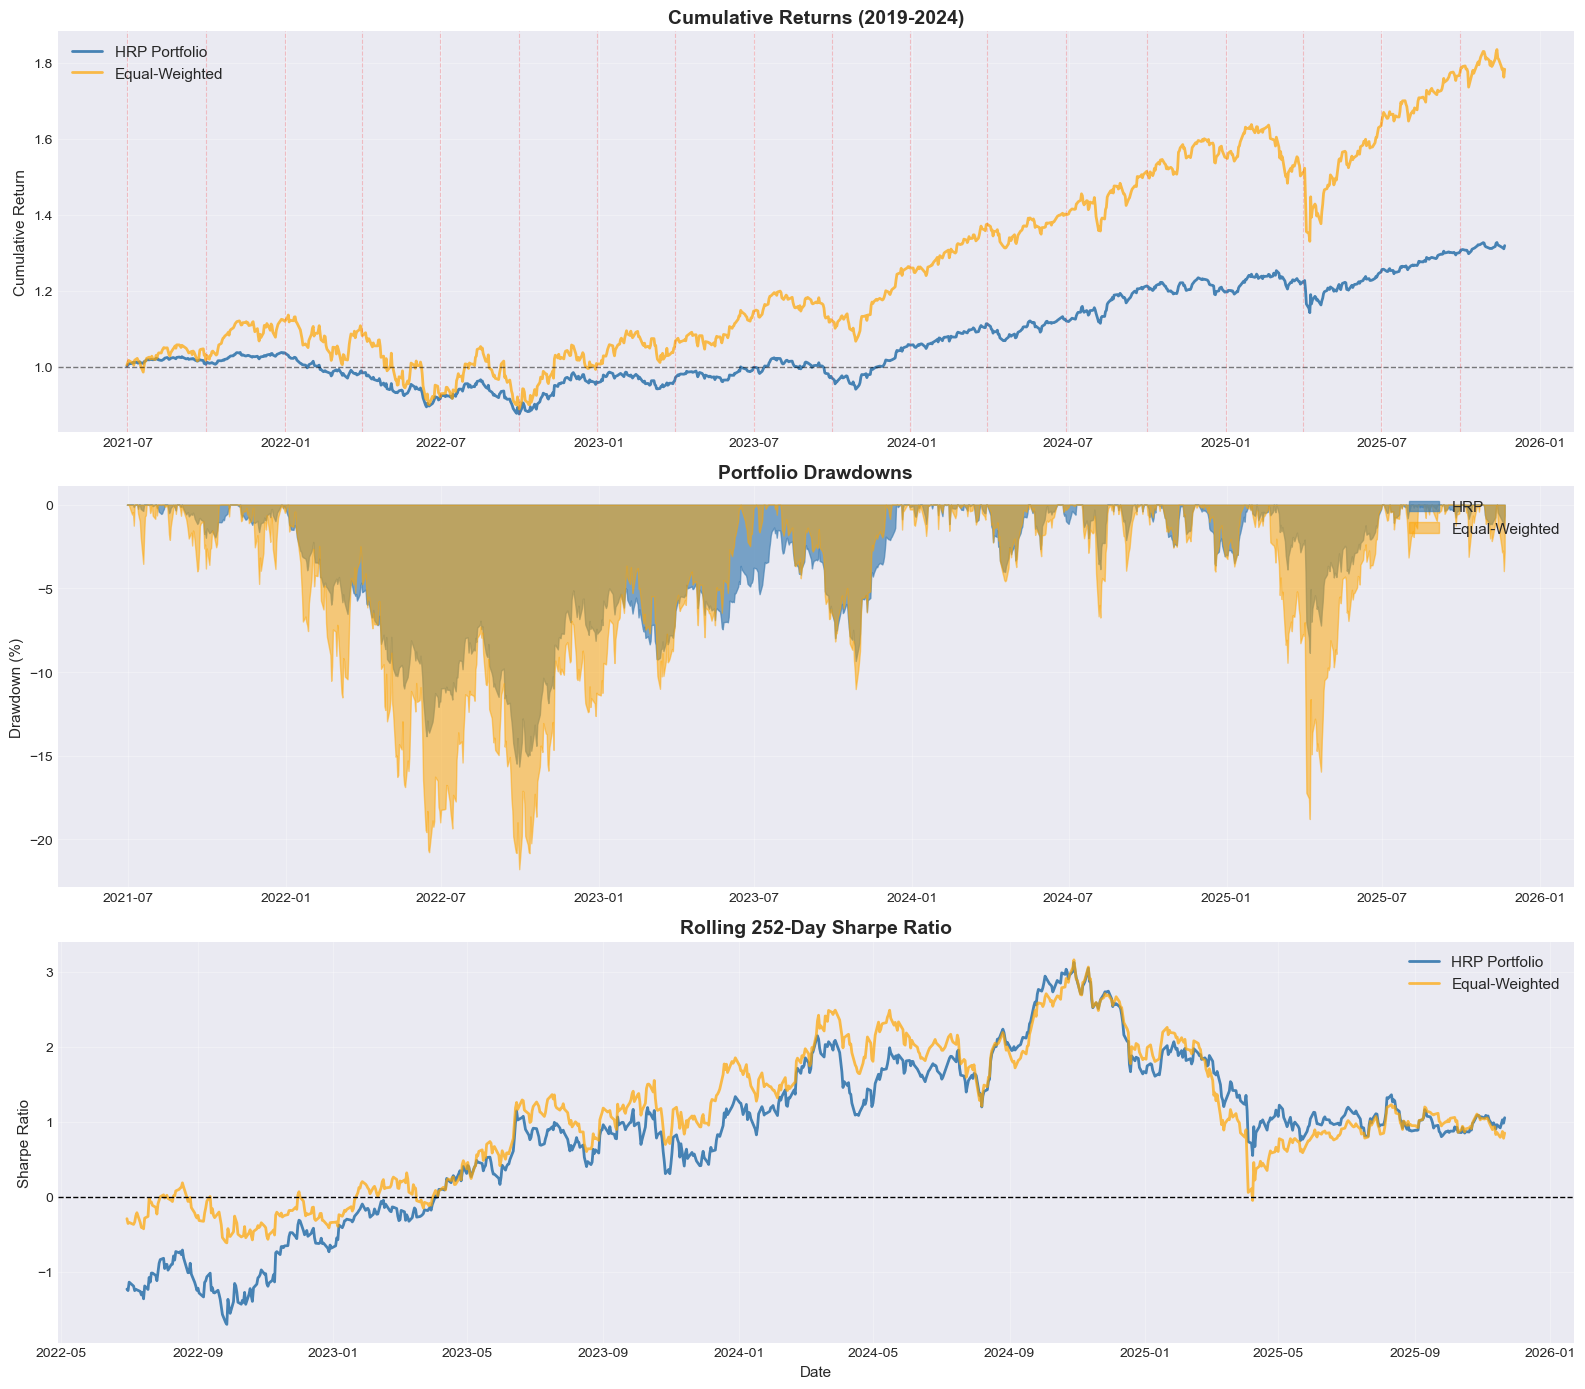

✅ Performance charts saved


In [19]:
"""
Visualize portfolio performance
"""

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Cumulative returns
ax1 = axes[0]
ax1.plot(hrp_cumulative.index, hrp_cumulative.values, 
        label='HRP Portfolio', linewidth=2, color='steelblue')
ax1.plot(equal_cumulative.index, equal_cumulative.values, 
        label='Equal-Weighted', linewidth=2, color='orange', alpha=0.7)
ax1.set_title('Cumulative Returns (2019-2024)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return', fontsize=11)
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.axhline(1, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Add rebalance markers
for rebal_date in hrp_rebal_dates:
    ax1.axvline(rebal_date, color='red', alpha=0.2, linestyle='--', linewidth=0.8)

# Drawdowns
ax2 = axes[1]
ax2.fill_between(hrp_drawdown.index, hrp_drawdown.values * 100, 0, 
                alpha=0.7, color='steelblue', label='HRP')
ax2.fill_between(equal_drawdown.index, equal_drawdown.values * 100, 0, 
                alpha=0.5, color='orange', label='Equal-Weighted')
ax2.set_title('Portfolio Drawdowns', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown (%)', fontsize=11)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Rolling Sharpe ratio (252-day)
ax3 = axes[2]
hrp_rolling_sharpe = (hrp_portfolio_returns.rolling(252).mean() * 252) / \
                     (hrp_portfolio_returns.rolling(252).std() * np.sqrt(252))
equal_rolling_sharpe = (equal_portfolio_returns.rolling(252).mean() * 252) / \
                       (equal_portfolio_returns.rolling(252).std() * np.sqrt(252))

ax3.plot(hrp_rolling_sharpe.index, hrp_rolling_sharpe.values, 
        label='HRP Portfolio', linewidth=2, color='steelblue')
ax3.plot(equal_rolling_sharpe.index, equal_rolling_sharpe.values, 
        label='Equal-Weighted', linewidth=2, color='orange', alpha=0.7)
ax3.axhline(0, color='black', linestyle='--', linewidth=1)
ax3.set_title('Rolling 252-Day Sharpe Ratio', fontsize=14, fontweight='bold')
ax3.set_ylabel('Sharpe Ratio', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'results/figures/hrp/04_performance_comparison.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("✅ Performance charts saved")


Weight history shape: (18, 55)
Dates: 18, Assets: 55


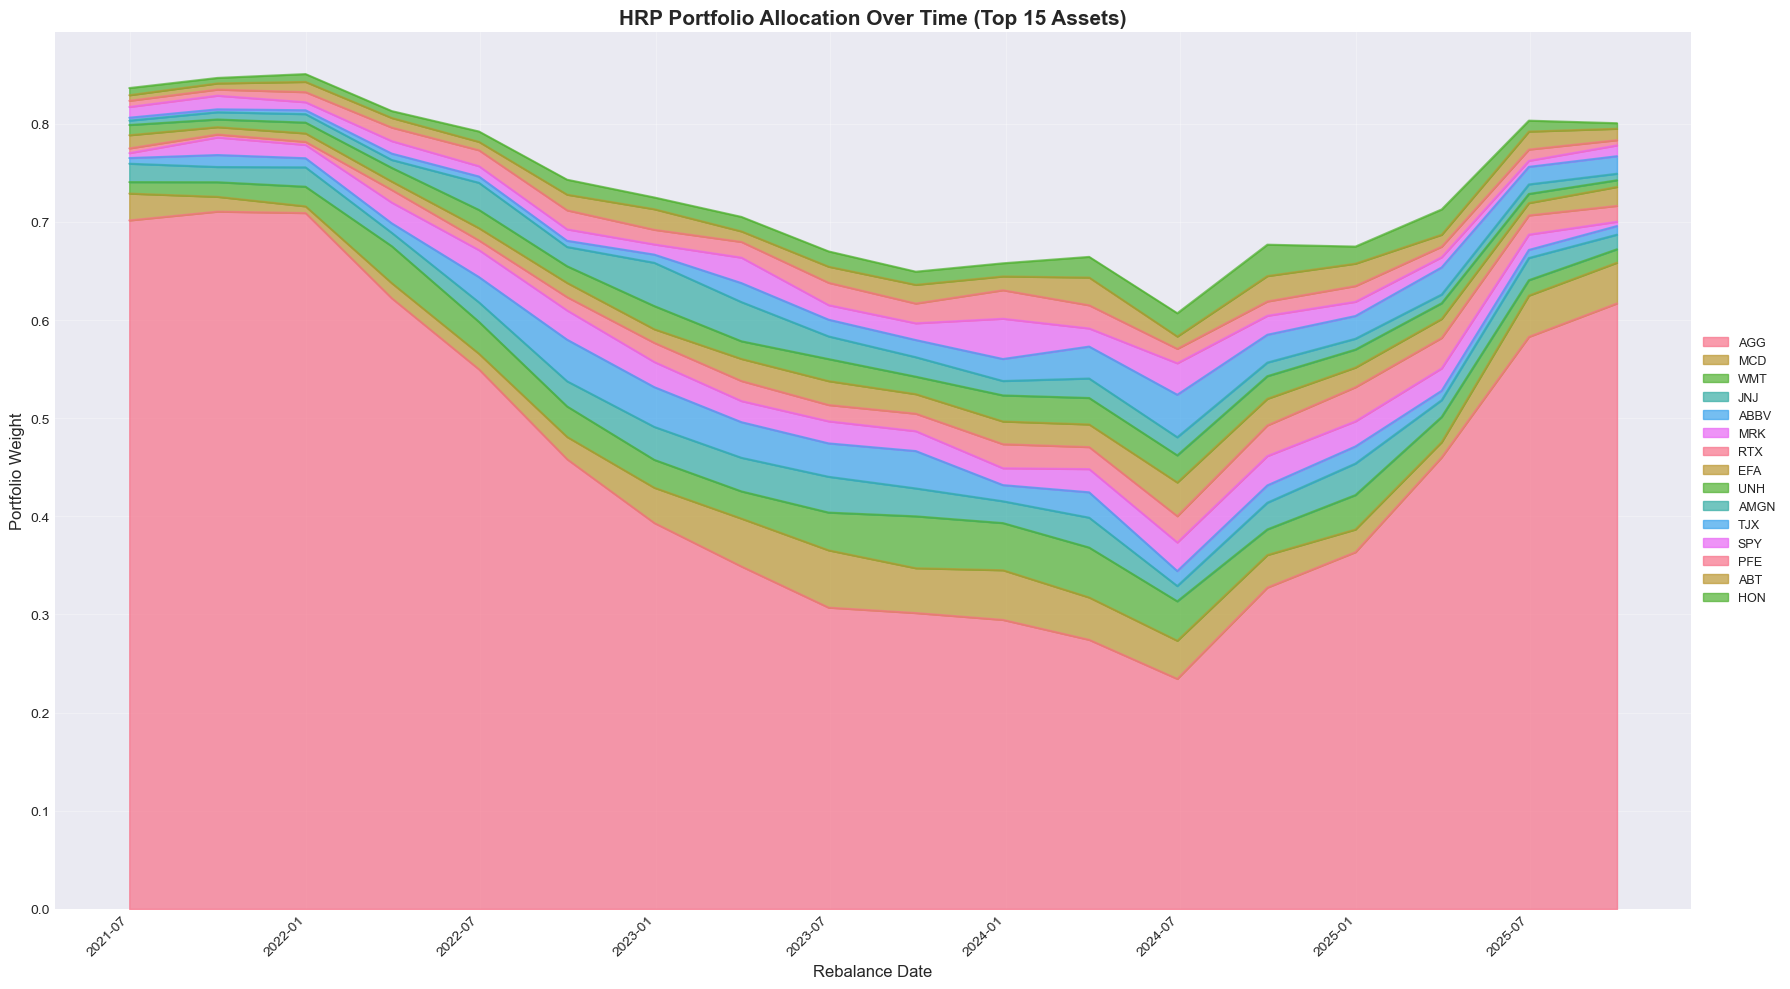

✅ Allocation over time chart saved

Average portfolio turnover per rebalance: 20.42%
Max portfolio turnover: 34.69%
Min portfolio turnover: 10.73%


In [20]:
"""
Visualize how allocations change over time
"""

# Extract weight history for visualization - CORRECTED VERSION
# We need to build DataFrame properly with correct columns

# Get the first 20 rebalance dates
num_rebalances_to_show = min(20, len(hrp_rebal_dates))
selected_dates = hrp_rebal_dates[:num_rebalances_to_show]

# Build weight history DataFrame properly
weight_data = {}
for date in selected_dates:
    if date in hrp_weights_over_time:
        weight_data[date] = hrp_weights_over_time[date]

# Create DataFrame from dictionary (dates as columns, tickers as index)
weight_history = pd.DataFrame(weight_data)

# Transpose so dates are rows, tickers are columns
weight_history = weight_history.T

print(f"Weight history shape: {weight_history.shape}")
print(f"Dates: {len(weight_history)}, Assets: {len(weight_history.columns)}")

# Plot top 15 allocations over time
top_15_avg = weight_history.mean(axis=0).sort_values(ascending=False).head(15)
weight_history_top15 = weight_history[top_15_avg.index]

fig, ax = plt.subplots(figsize=(18, 10))
weight_history_top15.plot(kind='area', stacked=True, ax=ax, alpha=0.7)
ax.set_title('HRP Portfolio Allocation Over Time (Top 15 Assets)', 
            fontsize=15, fontweight='bold')
ax.set_ylabel('Portfolio Weight', fontsize=12)
ax.set_xlabel('Rebalance Date', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(project_root / 'results/figures/hrp/05_allocation_over_time.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("✅ Allocation over time chart saved")

# Also show weight stability over time
weight_changes = weight_history.diff().abs().sum(axis=1)
print(f"\nAverage portfolio turnover per rebalance: {weight_changes.mean():.2%}")
print(f"Max portfolio turnover: {weight_changes.max():.2%}")
print(f"Min portfolio turnover: {weight_changes[weight_changes > 0].min():.2%}")


In [21]:
"""
Save HRP model and results
"""

import pickle

# Save latest HRP weights
hrp_model = {
    'weights': hrp_weights,
    'correlation_matrix': corr_matrix,
    'distance_matrix': dist_matrix,
    'linkage_matrix': linkage_matrix,
    'sorted_tickers': sorted_tickers,
    'cluster_assignments': cluster_assignments,
    'calculation_date': recent_returns.index[-1],
    'lookback_period': lookback_period
}

with open(project_root / 'models/hrp_model.pkl', 'wb') as f:
    pickle.dump(hrp_model, f)

print("✅ HRP model saved to models/hrp_model.pkl")

# Save weight history properly
weight_history_full = pd.DataFrame(hrp_weights_over_time)
weight_history_full.to_csv(project_root / 'results/metrics/hrp_weights_history.csv')
print("✅ Weight history saved")

# Save portfolio returns for later comparison
hrp_portfolio_returns.to_csv(project_root / 'results/metrics/hrp_portfolio_returns.csv')
print("✅ Portfolio returns saved")

print("\n" + "="*70)
print("HIERARCHICAL RISK PARITY COMPLETE")
print("="*70)
print(f"✅ HRP portfolio Sharpe ratio: {hrp_metrics['Sharpe Ratio']}")
print(f"✅ Equal-Weighted Sharpe ratio: {equal_metrics['Sharpe Ratio']}")

# Calculate improvement
hrp_sharpe_val = float(hrp_metrics['Sharpe Ratio'])
equal_sharpe_val = float(equal_metrics['Sharpe Ratio'])
improvement = hrp_sharpe_val - equal_sharpe_val
print(f"✅ Improvement vs Equal-Weighted: {improvement:.3f} Sharpe points")
print(f"✅ All results saved to results/")



✅ HRP model saved to models/hrp_model.pkl
✅ Weight history saved
✅ Portfolio returns saved

HIERARCHICAL RISK PARITY COMPLETE
✅ HRP portfolio Sharpe ratio: 0.527
✅ Equal-Weighted Sharpe ratio: 0.716
✅ Improvement vs Equal-Weighted: -0.189 Sharpe points
✅ All results saved to results/
